# Setting up, prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import keras_tuner
import keras
import pandas as pd
from tensorflow.keras import layers
from keras import metrics
from sklearn import preprocessing
import math  
import datetime
import tensorflow_decision_forests as tfdf
import os
from keras.utils import plot_model
import tensorflow_datasets as tfds
from keras.utils import plot_model
import pydot
# import graphviz

global w 
global h 

2023-12-03 01:21:13.037739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 01:21:13.037767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 01:21:13.037794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 01:21:13.046647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CHECK TENSOR USING GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2023-12-03 01:21:19.147130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 01:21:19.154363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 01:21:19.154673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See m

True

# Get data

## Get Data as if it's true data


In [27]:
# SEPERATE SUBJECTS TO DIFFERENT DATASET - NO SHUFFLE

dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles_train = ['female_1.mat','male_1.mat','male_2.mat']
dataFiles_test = ['female_2.mat','female_3.mat']
# dataFiles=['female_1.mat']

e = 2.718281828459045


def normalize_arr(arr,i):
    signal = arr.copy()
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = int(i/2)
    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))

    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data


def getData(dataFiles):
    data = [] #processed and normalised with pose_idx
    for file in dataFiles:
        data_path = dataDir+file
        print(data_path)
        mat = scipy.io.loadmat(data_path)
        mat.pop("__header__")
        mat.pop("__version__")
        mat.pop("__globals__")
        i=0

        plot_interval = 100
        plot_index = 0

        for channel in mat: 
        
            if(i%2==0):
                channel2 =  channel[:-1]
                channel2 += '2'
                sigs1 = mat[channel] 
                sigs2 = mat[channel2]
                sigs1_norm = []
                sigs2_norm = []

                for signal in sigs1:
                    # signal = normalize_arr(signal,i)
                    if(signal[0]<2):
                        sigs1_norm.append(signal)
                        sigs2_norm.append(signal)
                # for signal in sigs2:
                #     # signal = normalize_arr(signal,i)
                #     if(signal[0]<2):
                #         sigs2_norm.append(signal)

                if i==0:
                    data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                else:
                    None
                    data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                    data += data_lc
            i+=1
    return data
def get_nm_data(dataFiles):
    data = getData(dataFiles)
    print(np.array(data).shape)
    print(data[-3])

    data_nm = np.copy(data)[:,:2]
    data_nm.shape
    nm_c1 =  preprocessing.normalize([data_nm.T[0]]).T.flatten()
    nm_c2 =  preprocessing.normalize([data_nm.T[1]]).T.flatten()
    df_data_nm = pd.DataFrame(np.vstack((nm_c1,nm_c2)).T, columns = ['channel1','channel2'])

    label_arr=[]

    for row in data:
        label_arr.append(int(row[2]))
    print(label_arr)

    data_nm = df_data_nm.assign(label=label_arr)
    return data_nm



#==========================================
def GetSpacedElements(array, numElems = 4):
    return array[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]

#////////////////////============
def display_signals(b):
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    columns = 1
    rows = 2

    for index in range(1,2+1):
        idx = 0
        fig.add_subplot(rows, columns, index)
        for signal in b:
            plt.plot(signal[index-1],label=str(idx))
            idx += 1
        plt.title('channel '+str(index))
        plt.legend(ncol=1)
        
            
    plt.show()
    fig = plt.figure(figsize=(20, 20))
    columns = 2
    rows = 3
    idx = 0

    for signal in b:
        fig.add_subplot(rows, columns, idx+1)
        plt.plot(signal[0],color='blue',label=str(0))
        plt.plot(signal[1],color='orange',label=str(1))
        idx += 1
        plt.title('pose '+str(idx-1))
        plt.legend(ncol=1)
            
    plt.show()


def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        # row =np.pad(row,(0,n-n_len),'symmetric')
        row =np.pad(row,(0,n-n_len),'constant',constant_values=10)
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)
def signal_to_3channelimg(arr):
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts
def reshape_for_conv2d(t,w,h):
    train_size = int(len(t) * len(t[0])* len(t[0][0]) / (w*h))
    reshaped_tuple = t.reshape(train_size, w,h, 1)
    return reshaped_tuple



data_train_nm = get_nm_data(dataFiles_train)
data_test_nm = get_nm_data(dataFiles_test)



dataset_train = data_train_nm
dataset_test = data_test_nm

val_test_mask = np.random.rand(len(data_train_nm)) < 0.5

dataset_train = data_train_nm[val_test_mask]
dataset_val = data_train_nm[~val_test_mask]

img_w_h_len = 40
n = int(img_w_h_len * img_w_h_len / 2)

dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)



# print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)
print("X shape:",X.shape)

X_val = split_X(dataset_val_ar)
y_val = split_y(dataset_val_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_test = reshape_arr(X_test)
X_val = reshape_arr(X_val)



w = img_w_h_len
h = img_w_h_len
X = reshape_for_conv2d(X,w,h)
X_test = reshape_for_conv2d(X_test,w,h)
X_val = reshape_for_conv2d(X_val,w,h)
X_test = reshape_for_conv2d(X_test,w,h)




/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/female_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_2.mat
(539820, 3)
[-0.029808, 0.199706, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# DISPLAY
sample = 100
rate = sample * 6
print(rate)

test_d = np.copy(data_train_nm)
test_c = np.copy(data_test_nm)

if True:
    test_d=  GetSpacedElements(test_d,rate)
    test_c=  GetSpacedElements(test_c,rate)
test_d = test_d.T
test_c = test_c.T

b = np.array((np.hsplit(test_d, 6)))
a = np.array((np.hsplit(test_c, 6)))


print(test_d.shape)
print(b.shape)
display_signals(b)
display_signals(a)

# Bluetooth <placeholder>

In [4]:
# import bluetooth

# nearby_devices = bluetooth.discover_devices(lookup_names=True)
# print("Found {} devices.".format(len(nearby_devices)))

# for addr, name in nearby_devices:
#     print("  {} - {}".format(addr, name))

# COMBINE


## predict by sample

In [5]:
def max_voting(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num


In [6]:
load_model_1 = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
load_model_2 = keras.models.load_model('./models/tuned_model_loss_5.0_0.1_acc_us_15_11.keras')
# load_model_3 = model
load_model_3 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
load_model_4 = load_model_1
# load_model_4 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
# load_model_3 = keras.models.load_model('./models/model_0.4_40l_1c_new.keras')

2023-12-03 01:21:43.694717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 01:21:43.695044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 01:21:43.695331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
test_sample = 1

In [8]:
test_X_sample_rate = np.array_split(X_test,len(y_test)/(test_sample))
test_y_sample_rate = np.array_split(y_test,len(y_test)/(test_sample))
print(len(test_X_sample_rate))
np.array(test_X_sample_rate[1]).shape
tempt_y = []
for ys in test_y_sample_rate:
    tempt_y.append(ys[0])
test_y_sample_rate = tempt_y
test_y_sample_rate = np.array(test_y_sample_rate)
test_y_sample_rate



671


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

1200
(3, 1200)
(6, 3, 200)


In [17]:
test_X_sample_rate[0].flatten().shape

(1600,)

(100,)
1/1 [==============================] - 0s 23ms/step


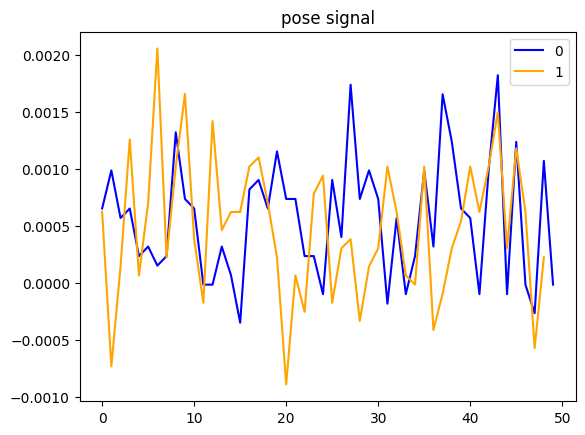

In [31]:
idx = 20
X_test_rate = test_X_sample_rate[idx]


XFlat = X_test_rate.flatten()
sample = 50 # max 200 for clean code sake
rate = sample *2
XFlat = GetSpacedElements(XFlat,rate)

print(XFlat.shape)
XFlat1=XFlat[0:int(len(XFlat)/2)]
XFlat2=XFlat[int(len(XFlat)/2):-1]
pred_rate = []

plt.plot(XFlat1,color='blue',label=str(0))
plt.plot(XFlat2,color='orange',label=str(1))
plt.title('pose '+"signal")
plt.legend(ncol=1)  
preds_1 = load_model_1.predict(X_test_rate)
preds_2 = load_model_2.predict(X_test_rate)
preds_3 = load_model_3.predict(X_test_rate)

pred_c = []
pred_c.append(preds_1)
pred_c.append(preds_2)
pred_c.append(preds_3)
pred_c = np.array(pred_c)
pred_c[0]

t = pred_c[0]

preds_label_c = []
for preds in pred_c:
    pred_label = []
    for prediction in preds:
        pred_label.append(np.argmax(prediction))
    pred_label = np.array(pred_label)
    preds_label_c.append(pred_label)
preds_label_c = np.array(preds_label_c)

ensemble_pred = []
for i in np.arange(len(X_test_rate)):
    i=i
    arr = []
    for pred in preds_label_c:
        arr.append(pred[i])
    ensemble_pred.append(max_voting(arr))
pred_rate.append(max_voting(ensemble_pred))

pred_rate = np.array(pred_rate)


In [ ]:
X_test_rate[0].shape
# XFlat = X_test_rate[0]

(40, 40, 1)

In [ ]:
# USE THIS ONE
pred_rate = []
plot_path = "../app/assets/signal.png"

for X_test_rate in test_X_sample_rate:
    XFlat = X_test_rate.flatten()
    sample = 50 # max 200 for clean code sake
    rate = sample *2
    XFlat = GetSpacedElements(XFlat,rate)

    print(XFlat.shape)
    XFlat1=XFlat[0:int(len(XFlat)/2)]
    XFlat2=XFlat[int(len(XFlat)/2):-1]
    pred_rate = []

    plt.plot(XFlat1,color='blue',label=str(0))
    plt.plot(XFlat2,color='orange',label=str(1))
    plt.title("sEmg signal")
    plt.legend(ncol=1)  
    plt.savefig(plot_path)
    plt.pause(0.0001)
    plt.clf()


    preds_1 = load_model_1.predict(X_test_rate)
    preds_2 = load_model_2.predict(X_test_rate)
    preds_3 = load_model_3.predict(X_test_rate)

    pred_c = []
    pred_c.append(preds_1)
    pred_c.append(preds_2)
    pred_c.append(preds_3)
    pred_c = np.array(pred_c)
    pred_c[0]

    t = pred_c[0]

    preds_label_c = []
    for preds in pred_c:
        pred_label = []
        for prediction in preds:
            pred_label.append(np.argmax(prediction))
        pred_label = np.array(pred_label)
        preds_label_c.append(pred_label)
    preds_label_c = np.array(preds_label_c)

    ensemble_pred = []
    for i in np.arange(len(X_test_rate)):
        i=i
        arr = []
        for pred in preds_label_c:
            arr.append(pred[i])
        ensemble_pred.append(max_voting(arr))
    pred_rate.append(max_voting(ensemble_pred))
# max_voting(pred_rate)
pred_rate = np.array(pred_rate)


1/1 [==============================] - 0s 23ms/step


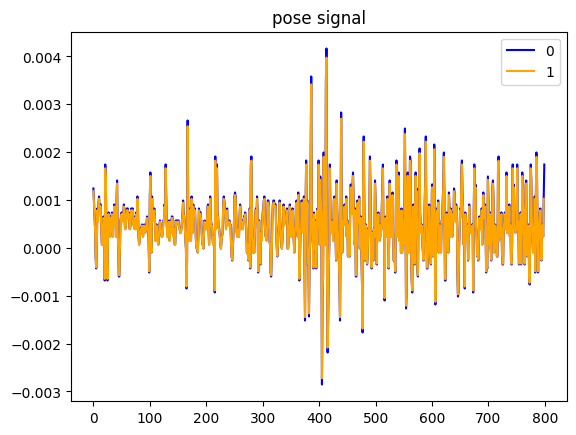

In [ ]:
pred_rate = []
for X_test_rate in test_X_sample_rate:
    # plt.plot(X_test_rate.flatten(),color='blue',label=str(0))
    # plt.plot(test_y_sample_rate[0],color='orange',label=str(1))
    plt.plot(XFlat1,color='blue',label=str(0))
    plt.plot(XFlat2,color='orange',label=str(1))
    plt.title('pose '+"signal")
    plt.legend(ncol=1)  
    preds_1 = load_model_1.predict(X_test_rate)
    preds_2 = load_model_2.predict(X_test_rate)
    preds_3 = load_model_3.predict(X_test_rate)

    pred_c = []
    pred_c.append(preds_1)
    pred_c.append(preds_2)
    pred_c.append(preds_3)
    pred_c = np.array(pred_c)
    pred_c[0]

    t = pred_c[0]

    preds_label_c = []
    for preds in pred_c:
        pred_label = []
        for prediction in preds:
            pred_label.append(np.argmax(prediction))
        pred_label = np.array(pred_label)
        preds_label_c.append(pred_label)
    preds_label_c = np.array(preds_label_c)

    ensemble_pred = []
    for i in np.arange(len(X_test_rate)):
        i=i
        arr = []
        for pred in preds_label_c:
            arr.append(pred[i])
        ensemble_pred.append(max_voting(arr))
    pred_rate.append(max_voting(ensemble_pred))
    break
# max_voting(pred_rate)
pred_rate = np.array(pred_rate)


In [ ]:
pred_rate = []
for X_test_rate in test_X_sample_rate:
    preds_1 = load_model_1.predict(X_test_rate)
    preds_2 = load_model_2.predict(X_test_rate)
    preds_3 = load_model_3.predict(X_test_rate)

    pred_c = []
    pred_c.append(preds_1)
    pred_c.append(preds_2)
    pred_c.append(preds_3)
    pred_c = np.array(pred_c)
    pred_c[0]

    t = pred_c[0]

    preds_label_c = []
    for preds in pred_c:
        pred_label = []
        for prediction in preds:
            pred_label.append(np.argmax(prediction))
        pred_label = np.array(pred_label)
        preds_label_c.append(pred_label)
    preds_label_c = np.array(preds_label_c)

    ensemble_pred = []
    for i in np.arange(len(X_test_rate)):
        i=i
        arr = []
        for pred in preds_label_c:
            arr.append(pred[i])
        ensemble_pred.append(max_voting(arr))
    pred_rate.append(max_voting(ensemble_pred))
# max_voting(pred_rate)
pred_rate = np.array(pred_rate)


2023-12-03 00:50:04.667484: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-03 00:50:05.244612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5], dtype='uint8')
b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 4, 1, 1, 3, 3, 3, 4, 1, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 5,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 3, 3, 4,
       3, 1, 5, 5, 5, 2, 3, 5, 5, 5, 3, 5, 5, 5, 5, 2, 2, 2, 2, 5, 5, 5,
       3, 5])

matrix1_flat = a.flatten()
matrix2_flat = b.flatten()

similarity_ratio = cosine_similarity([matrix1_flat], [matrix2_flat])[0][0]
print(similarity_ratio)

0.9071463261468489


In [ ]:
import difflib

l1 = test_y_sample_rate
l2 = pred_rate

sm = difflib.SequenceMatcher(None,l1,l2)
sm.ratio()


0.004470938897168405

In [ ]:
pred_rate

array([0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 1, 1, 1, 0, 0,
       3, 3, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 4, 4, 1, 4,
       4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 1,
       1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,



========================= test_y_sample_rate ==========================
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 

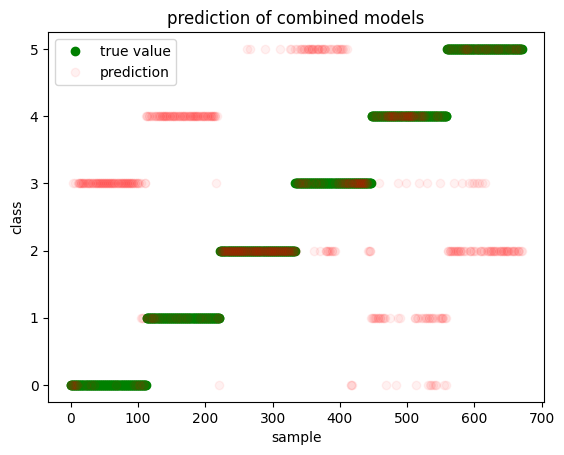

In [ ]:
    print("\n\n========================= test_y_sample_rate ==========================\n",test_y_sample_rate)
    print("\n\n====================== pred_rate =============================\n",pred_rate)


    plt.plot(test_y_sample_rate,'o',color ='green', label="true value")
    plt.plot( pred_rate, 'o', color='red',alpha=0.055, label='prediction')
    
    plt.xlabel("sample")
    plt.ylabel("class")
    plt.title("prediction of combined models")
    plt.legend(ncol=1)

    plt.show()

In [ ]:
# matrix1_flat = a.flatten()
# matrix2_flat = b.flatten()
matrix1_flat = test_y_sample_rate
matrix2_flat = pred_rate

similarity_ratio = cosine_similarity([matrix1_flat], [matrix2_flat])[0][0]
print(similarity_ratio)

0.7633882087446169


In [ ]:
val = str(pred_rate[0])+";"
val

'0;'

In [ ]:
import serial
import time
port="/dev/rfcomm0"
bluetooth = serial.Serial(port=port,   baudrate=9600)
for pred in pred_rate:
    pose  = str(pred) + ";"
    bluetooth.write(bytes(pose,   'utf-8'))
    time.sleep(1.2)
    print(pose)

SerialException: [Errno 2] could not open port /dev/rfcomm0: [Errno 2] No such file or directory: '/dev/rfcomm0'